# Topic Modeling with Unsupervised Learning

In [60]:
from utils.db_conn import query
import seaborn as sns
import requests

## Import and clean the data from S3

Our data is been scrapped from youtube. We use some channel that do daily technical analysis on the price of Bitcoin. This data is stored in S3 AWS service.

In [61]:
# get all the file names from db
list_ids = [id[0] for id in query('query_video_ids', ['2022-05-01', '2022-05-30'])]

# load the data into a list
data = []
for id in list_ids:
    url = f'https://youtube-joao-crypto.s3.eu-central-1.amazonaws.com/{id}.txt'
    response = requests.get(url)
    for t in response.text.split('\n'):
        # we only want text or sentences with numbers
        if any(map(str.isdigit, t)):
            data.append(t)

data[:5]

['currently sitting at 29',
 '740 dollars so continues to battle',
 'shorting off of the 21 ema targeting',
 '26 000 and as low down as 19 thousand',
 'into that 21 ema on a weekly time frame']

### Save the data to txt

In [2]:
# with open('utils/prodigy/data.txt', 'w') as f:
#     for t in data:
#         f.write(t + '\n')

### Use spacy NER module to clean text

Text can be messy. We notice that we found diferent variantions of prices, for example: 29 000, 29.3, 29.3k, etc... The best way to clean this is to use a NER model to detect a price in the text and clean that piece of text. Not perfect, but if we had more time we could develop a better system.

In [3]:
import spacy

nlp = spacy.load("utils/prodigy/model/model-best", disable=["tagger", "parser", "attribute_ruler", "lemmatizer"])

def clean_text(text):
    text = text.replace('000', '')
    text = text.replace('00', '')
    text = text.replace('k', '')
    text = text.replace('.', '')
    text = text[:2]

    return text

final = []
for line in data:
    doc = nlp(line)
    final.append(" ".join([clean_text(word.text)+'k' if word.ent_type_ else word.text for word in doc]))

final[:5]

f:\uml\venv\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


['currently sitting at 29k',
 '740 dollars so continues to battle',
 'shorting off of the 21 ema targeting',
 '26k k and as low down as 19k thousand',
 'into that 21 ema on a weekly time frame']

## BERTopic

BERTopic uses BERT and transformers to vectorize the data. After we it will apply a dimensionality reduction techinque with UMAP to reduce from 768 dimensions to 2 dimensions. UMAP was recommended from BERTopic documentation. After we use HDBSCAN to find clusters.

### Embeddings

In [5]:
from sentence_transformers import SentenceTransformer

# sentence-transformers model
embedding_model = SentenceTransformer('all-mpnet-base-v2')

# embed the text into vectors
embeddings = embedding_model.encode(final)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda


Batches:   0%|          | 0/188 [00:00<?, ?it/s]

### Dimensionality reduction

f:\uml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

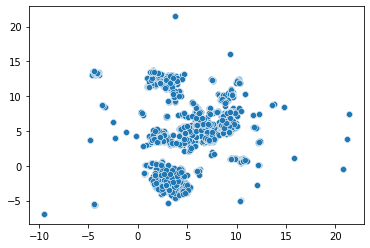

In [28]:
import umap

umap_model = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.01, random_state=42)
mapper = umap_model.fit_transform(embeddings)
sns.scatterplot(mapper.T[0], mapper.T[1])

### Dimensionality reduction and clustering model

<AxesSubplot:>

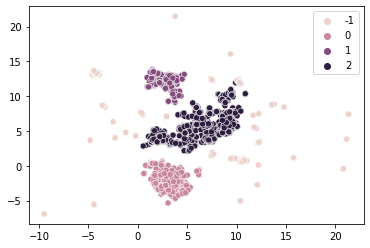

In [64]:
import hdbscan

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=150,
                        prediction_data=True, gen_min_span_tree=True)
hdbscan_model.fit(mapper)

sns.scatterplot(mapper.T[0], mapper.T[1], hue=hdbscan_model.labels_)

### BERTopic

Finally we use BERTopic to put everything together and find our topics. We use CountVectorizer to apply n_gram and stopwords.

In [62]:
from bertopic import BERTopic

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english')) + ['wave', 'waves', 'febonacci', 'fibonacci', 'level', 'yeah', 'could',
                                                'would', 'complete', 'finished', 'already', 'came', 'come'
                                                'uh', 'retracement', '618', '80', 'cents', 'k']

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=10,
    nr_topics=3,
    language='english',
    calculate_probabilities=True,
    verbose=False
)

topics, probs = model.fit_transform(final)

In [63]:
model.visualize_barchart(n_words=6)